In [201]:
import torch
import pandas as pd
import statsmodels.api
import matplotlib.pyplot as plt

### Lendo arquivo

In [202]:
data = statsmodels.api.datasets.get_rdataset(dataname='mtcars').data

In [203]:
data.nunique()

mpg     25
cyl      3
disp    27
hp      22
drat    22
wt      29
qsec    30
vs       2
am       2
gear     3
carb     6
dtype: int64

fazendo dummies das colunas

In [204]:
data_ = pd.get_dummies(
    data = data, columns=['cyl', 'vs', 'am', 'gear', 'carb'], dtype=int)

In [205]:
y = data_['mpg'].values.reshape(-1, 1)
X = data_.drop( columns=['mpg'] ).values

In [206]:
X.shape

(32, 21)

criando dataloader

In [207]:
X_ = torch.tensor( data=X, dtype=torch.float32 )
y_ = torch.tensor( data=y, dtype=torch.float32 )

In [208]:
X_[:, :5] = (X_[:, :5] - (X_[:, :5].mean(dim=0))) /  X_[:, :5].std(dim=0)

In [209]:
X_[0, :]

tensor([-0.5706, -0.5351,  0.5675, -0.6104, -0.7772,  0.0000,  1.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000])

In [210]:
tensor_ = torch.utils.data.TensorDataset(X_, y_)
train_ = torch.utils.data\
                    .DataLoader( tensor_, batch_size=18, shuffle=True)

definindo modelo, pesos....

In [211]:
weight = torch.randn(21)
weight.requires_grad_()
bias   = torch.zeros(1, requires_grad=True)

def modelo( X ):
    return X @ weight.reshape(-1, 1) + bias

In [212]:
def huber_loss( input_, output_, delta=1.0, alpha=0.01):
    erro_ = (input_ - output_)
    pequeno_erro = torch.abs(erro_) <= delta

    squared_loss = 0.5 * (erro_.pow(2))
    linear_loss  = delta *  ( torch.abs(erro_) - 0.5  * delta)
    return torch.where( 
        pequeno_erro, squared_loss, linear_loss
    ).mean()

def MSE_loss(input_, output_):
    return torch.sqrt( (input_ - output_).pow(2).mean() )

In [213]:
lr = 0.01
n_epochs = 20

for epoch in range(n_epochs):
    for xbatch, ybatch in train_:

        pred = modelo(xbatch) 

        loss = MSE_loss( ybatch, pred)

        loss.backward()

    with torch.no_grad():
        weight -= weight.grad * lr
        bias   -= bias.grad * lr

        weight.grad.zero_()
        bias.grad.zero_()
    
    if (n_epochs < 20):
        print(f'Epoch {epoch} --- Loss : {loss.item():3f}')
    else:
        if n_epochs % 10 == 0:
            print(f'Epoch {epoch} --- Loss : {loss.item():3f}')


Epoch 0 --- Loss : 18.923468
Epoch 1 --- Loss : 20.935808
Epoch 2 --- Loss : 21.159227
Epoch 3 --- Loss : 18.858271
Epoch 4 --- Loss : 18.534163
Epoch 5 --- Loss : 20.894606
Epoch 6 --- Loss : 21.919210
Epoch 7 --- Loss : 21.116896
Epoch 8 --- Loss : 21.464712
Epoch 9 --- Loss : 20.662981
Epoch 10 --- Loss : 20.411331
Epoch 11 --- Loss : 19.386984
Epoch 12 --- Loss : 20.174530
Epoch 13 --- Loss : 19.058064
Epoch 14 --- Loss : 20.398359
Epoch 15 --- Loss : 18.641706
Epoch 16 --- Loss : 17.273748
Epoch 17 --- Loss : 19.950155
Epoch 18 --- Loss : 19.525112
Epoch 19 --- Loss : 19.031313


In [214]:
with torch.no_grad():
    pred_ = modelo(X_)

In [215]:
from sklearn.metrics import *

In [216]:
pred_.shape, y_.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [217]:
root_mean_squared_error(y_.numpy(), pred_.detach().numpy())

19.57974

In [218]:
r2_score(y_.numpy(), pred_.detach().numpy())

-9.894498825073242

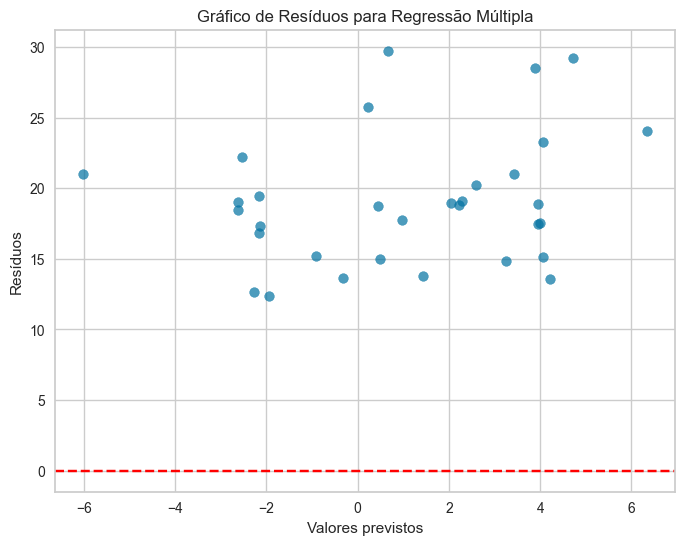

In [219]:
plt.figure(figsize=(8, 6))
plt.scatter(pred_, (y_ - pred_), alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Valores previstos")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos para Regressão Múltipla")
plt.show()
